In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Load data
df = pd.read_csv('Teacher_3033_CDATutterancesWithCodes.csv')
df['conversation_id'] = (df['speaker'] != df['speaker'].shift()).cumsum()
conversations = df.groupby('conversation_id')['utterance'].apply(' '.join).tolist()

In [3]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(conversations)

In [4]:
# Apply LDA
num_topics = 20  # Define number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda.fit_transform(X_tfidf)

In [5]:
# Clustering and evaluation
def evaluate_clustering(X, max_clusters=30):
    kmeans_metrics = {'inertia': [], 'silhouette': [], 'labels': []}
    em_metrics = {'aic': [], 'bic': [], 'silhouette': [], 'labels': []}
    
    for k in tqdm(range(2, max_clusters + 1), desc="Evaluating clusters"):
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(X)
        kmeans_metrics['inertia'].append(kmeans.inertia_)
        kmeans_metrics['silhouette'].append(silhouette_score(X, kmeans_labels))
        kmeans_metrics['labels'].append(kmeans_labels)
        
        # Expectation Maximization
        em = GaussianMixture(n_components=k, random_state=42, n_init=5)
        em_labels = em.fit_predict(X)
        em_metrics['aic'].append(em.aic(X))
        em_metrics['bic'].append(em.bic(X))
        em_metrics['silhouette'].append(silhouette_score(X, em_labels))
        em_metrics['labels'].append(em_labels)
    
    return kmeans_metrics, em_metrics

kmeans_metrics, em_metrics = evaluate_clustering(X_topics)

Evaluating clusters: 100%|█████████████████████████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


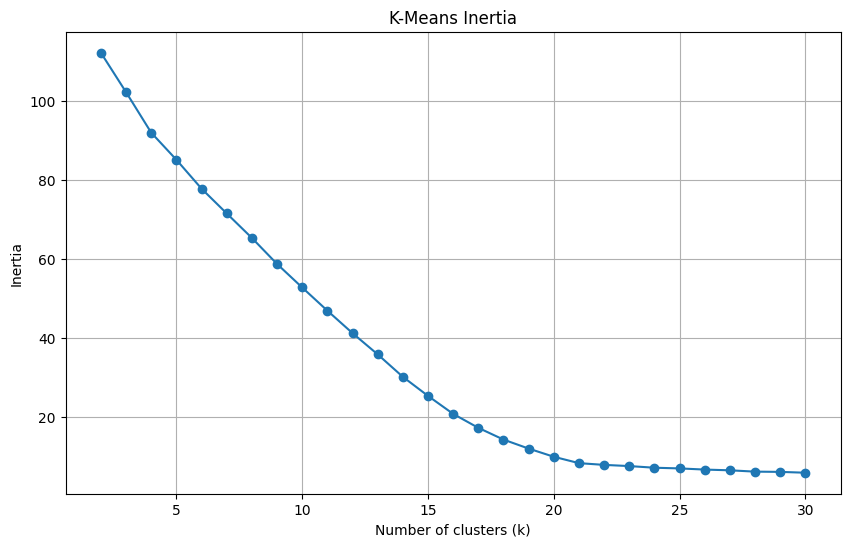

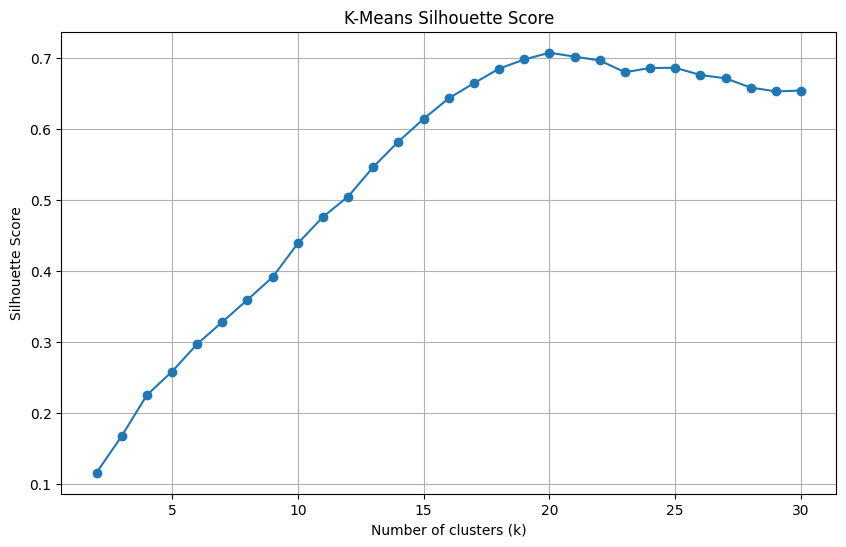

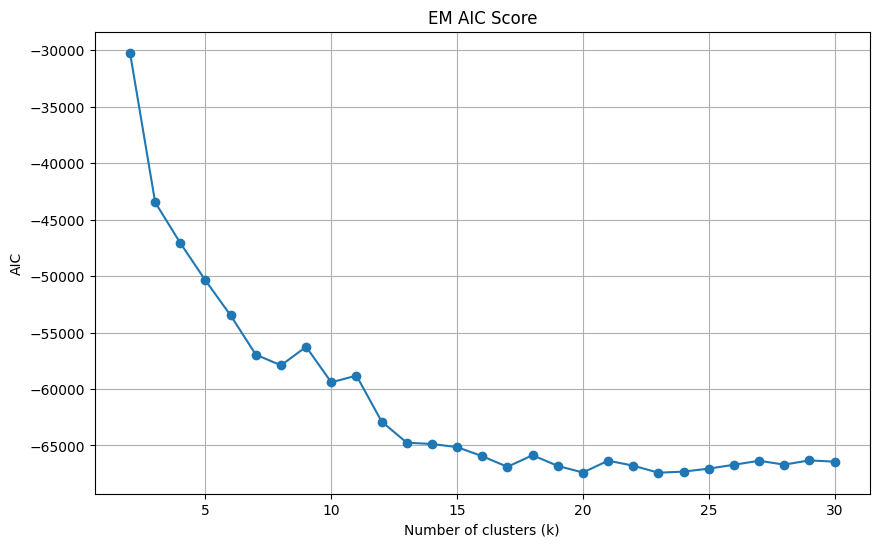

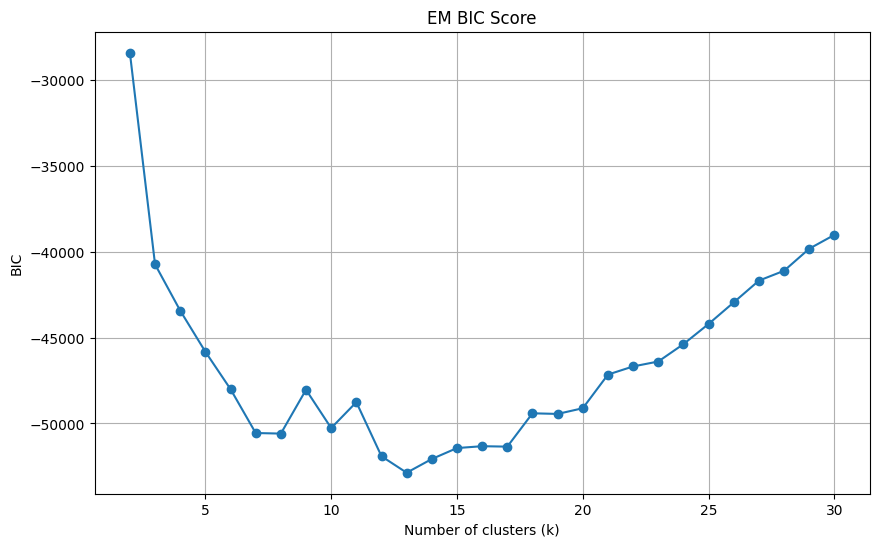

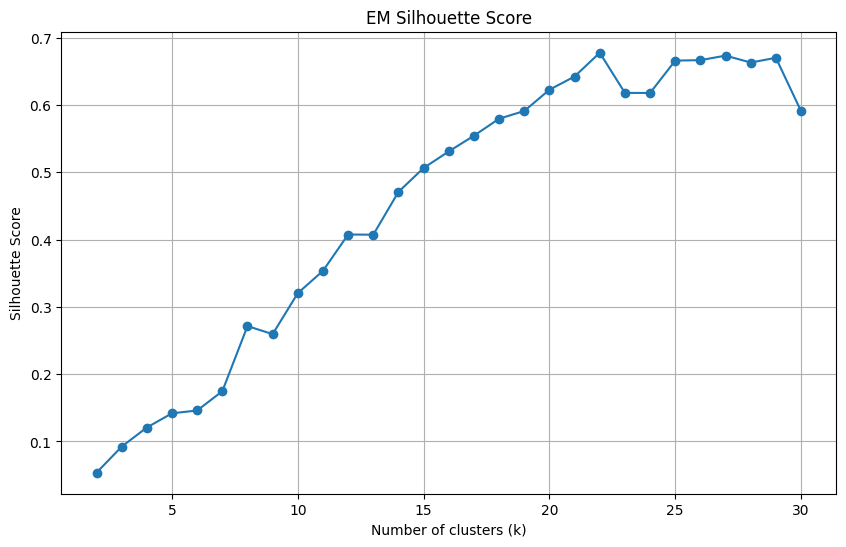

In [6]:
# Plotting functions
def plot_metric(metric_values, title, ylabel, xlabel="Number of clusters (k)"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, len(metric_values) + 2), metric_values, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

plot_metric(kmeans_metrics['inertia'], "K-Means Inertia", "Inertia")
plot_metric(kmeans_metrics['silhouette'], "K-Means Silhouette Score", "Silhouette Score")
plot_metric(em_metrics['aic'], "EM AIC Score", "AIC")
plot_metric(em_metrics['bic'], "EM BIC Score", "BIC")
plot_metric(em_metrics['silhouette'], "EM Silhouette Score", "Silhouette Score")

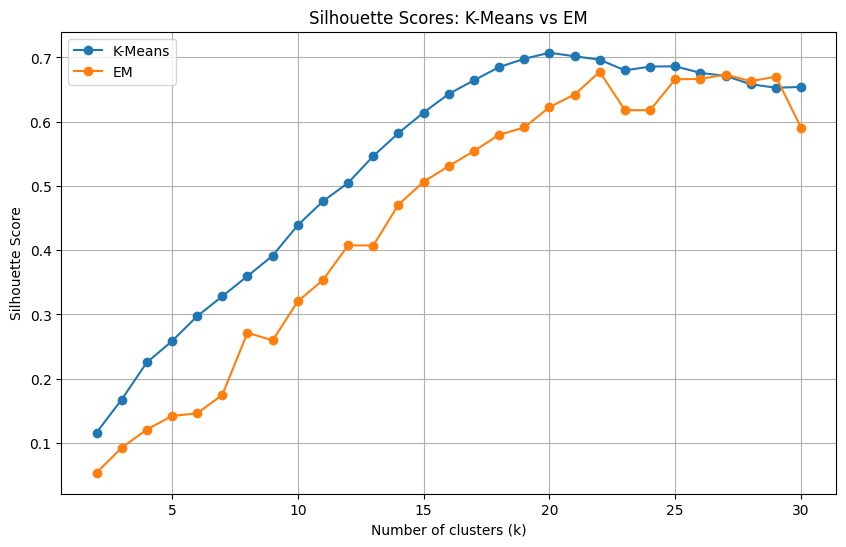

In [7]:
# Compare K-Means and EM silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(kmeans_metrics['silhouette']) + 2), kmeans_metrics['silhouette'], marker='o', label='K-Means')
plt.plot(range(2, len(em_metrics['silhouette']) + 2), em_metrics['silhouette'], marker='o', label='EM')
plt.title("Silhouette Scores: K-Means vs EM")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Find optimal number of clusters
optimal_k_kmeans = np.argmax(kmeans_metrics['silhouette']) + 2
optimal_k_em = np.argmax(em_metrics['silhouette']) + 2

print(f"Optimal number of clusters (K-Means): {optimal_k_kmeans}")
print(f"Optimal number of clusters (EM): {optimal_k_em}")

Optimal number of clusters (K-Means): 20
Optimal number of clusters (EM): 22


In [9]:
# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_topics_2d = tsne.fit_transform(X_topics)

In [10]:
# Visualize clusters
def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.grid(True)
    plt.show()

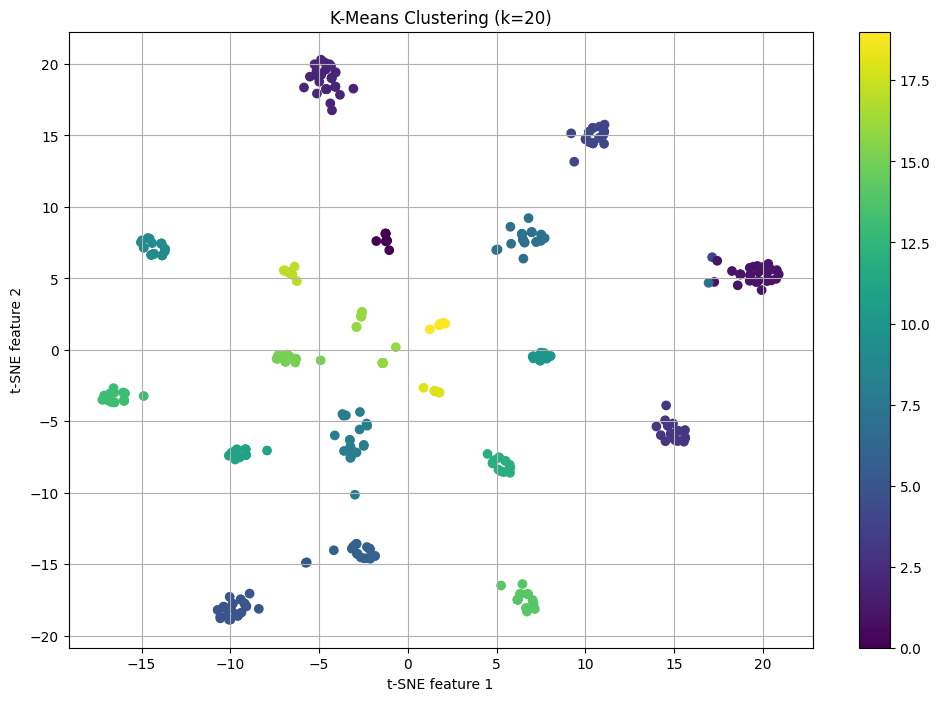

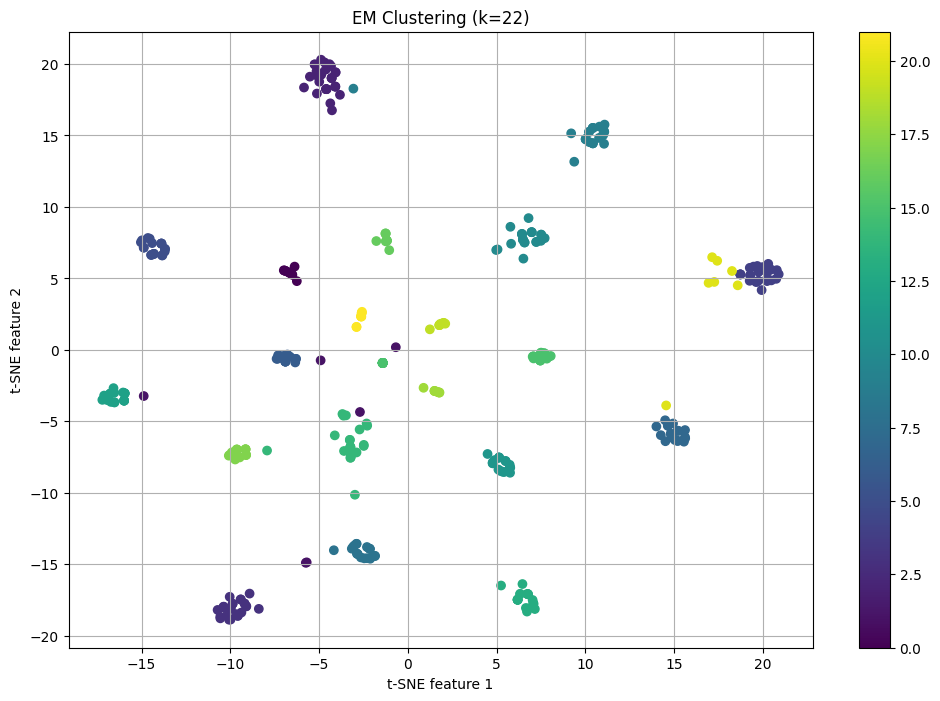

In [11]:
# Plot optimal clusters for K-Means and EM
plot_clusters(X_topics_2d, kmeans_metrics['labels'][optimal_k_kmeans-2], f'K-Means Clustering (k={optimal_k_kmeans})')
plot_clusters(X_topics_2d, em_metrics['labels'][optimal_k_em-2], f'EM Clustering (k={optimal_k_em})')

In [12]:
# Add cluster assignments to the original dataset
df['KMeans_Cluster'] = kmeans_metrics['labels'][optimal_k_kmeans-2][df['conversation_id'] - 1]
df['EM_Cluster'] = em_metrics['labels'][optimal_k_em-2][df['conversation_id'] - 1]

In [13]:
# Remove rows with NaN values in the relevant columns
df_clean = df.dropna(subset=['ut', 'KMeans_Cluster', 'EM_Cluster'])

In [14]:
# Convert 'ut' column to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
df_clean['ut_encoded'] = label_encoder.fit_transform(df_clean['ut'])

C:\Users\soon1\AppData\Local\Temp\ipykernel_13280\1034710957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ut_encoded'] = label_encoder.fit_transform(df_clean['ut'])


In [15]:
# Evaluate clustering against human-coded labels
ari_kmeans = adjusted_rand_score(df_clean['ut_encoded'], df_clean['KMeans_Cluster'])
nmi_kmeans = normalized_mutual_info_score(df_clean['ut_encoded'], df_clean['KMeans_Cluster'])
ari_em = adjusted_rand_score(df_clean['ut_encoded'], df_clean['EM_Cluster'])
nmi_em = normalized_mutual_info_score(df_clean['ut_encoded'], df_clean['EM_Cluster'])

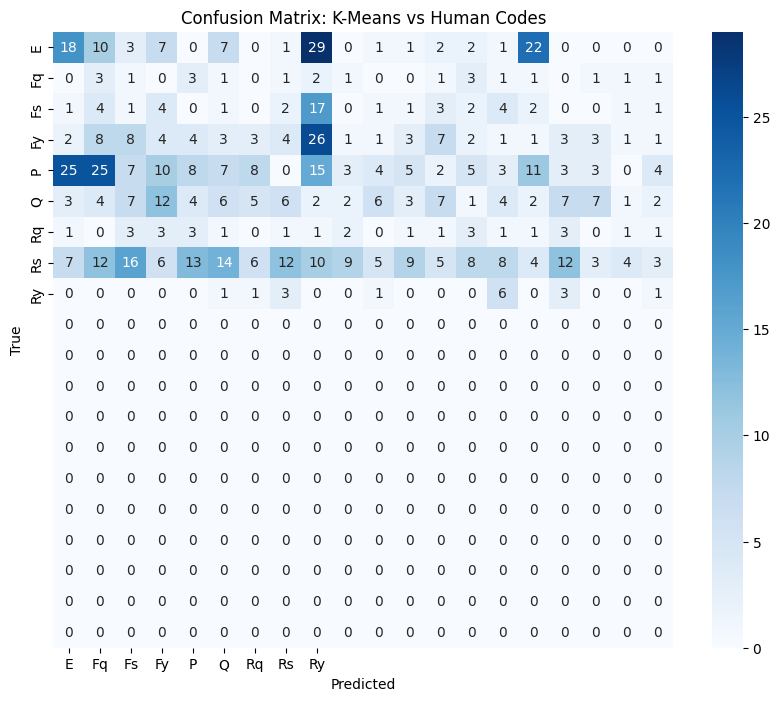

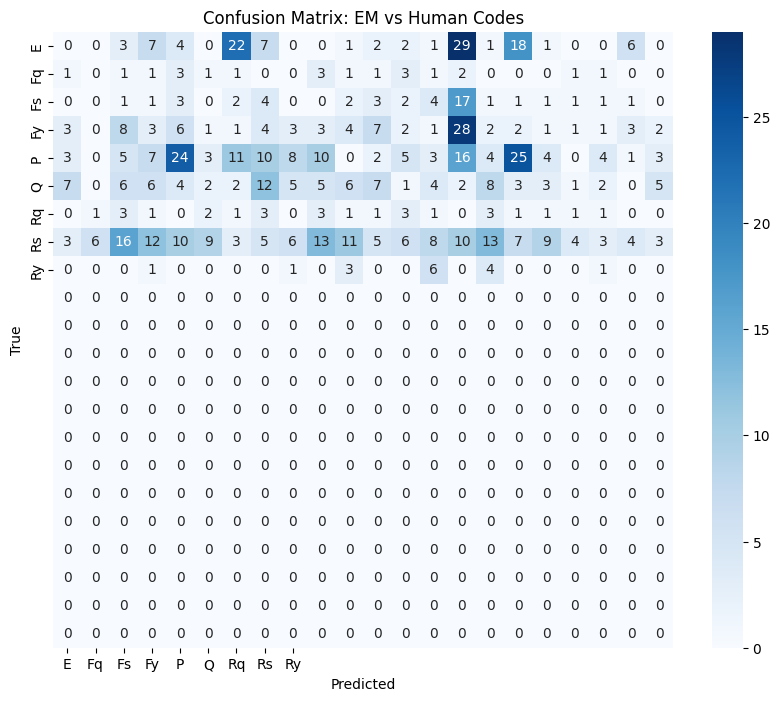

In [16]:
# Visualize comparison with confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(df_clean['ut_encoded'], df_clean['KMeans_Cluster'], 'Confusion Matrix: K-Means vs Human Codes')
plot_confusion_matrix(df_clean['ut_encoded'], df_clean['EM_Cluster'], 'Confusion Matrix: EM vs Human Codes')

In [17]:
# Save the updated dataset
df.to_csv('Teacher_3033_CDATutterances_with_clusters.csv', index=False, encoding='utf-8-sig')
print("Dataset with cluster assignments saved as 'Teacher_3033_CDATutterances_with_clusters.csv'")

Dataset with cluster assignments saved as 'Teacher_3033_CDATutterances_with_clusters.csv'


In [18]:
# Display a sample of the dataset with cluster assignments
print(df[['utterance', 'ut', 'KMeans_Cluster', 'EM_Cluster']].head(10))

                                           utterance  ut  KMeans_Cluster  \
0  Alright, let us do science. Who wants to do ca...   P               2   
1  Guys, as we go through the review, pay attenti...   P               2   
2  Alright? Stephanie your question is Number 8, ...   Q               2   
3                       Electricity? I do not know.   Rs               5   
4  Okay. Electricity would be correct so I cannot...  Fy               7   
5                        What flows in water, Curt?    Q               7   
6                                           Current.  Rs              11   
7                                Current very good!   Fy               7   
8                      Ed, what flows in the water?    Q               7   
9                                         Electrons.  Rs              12   

   EM_Cluster  
0           9  
1           9  
2           9  
3           1  
4          10  
5          10  
6          17  
7          10  
8          10  
9  

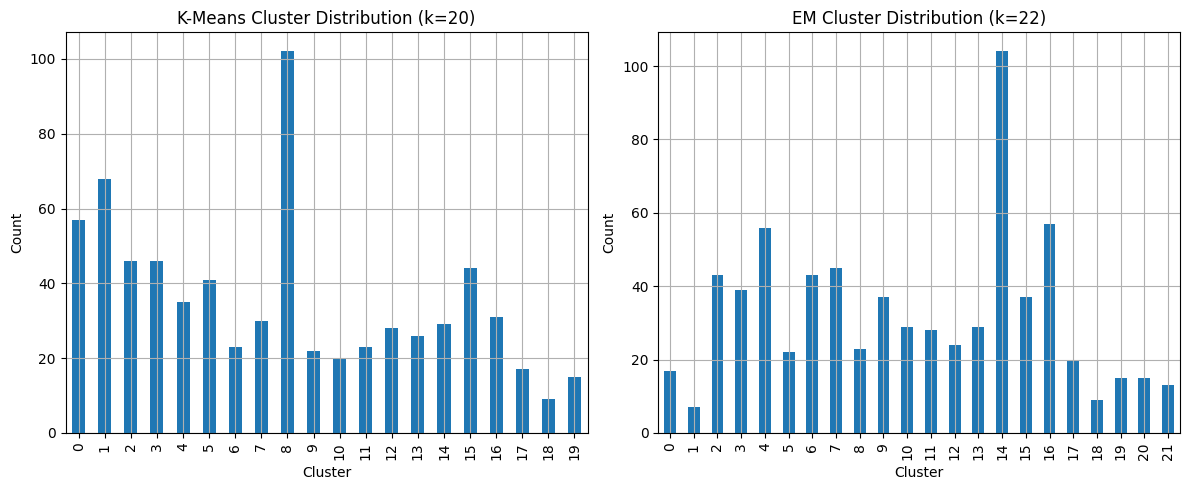

In [19]:
# Analyze cluster distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['KMeans_Cluster'].value_counts().sort_index().plot(kind='bar')
plt.title(f'K-Means Cluster Distribution (k={optimal_k_kmeans})')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
df['EM_Cluster'].value_counts().sort_index().plot(kind='bar')
plt.title(f'EM Cluster Distribution (k={optimal_k_em})')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


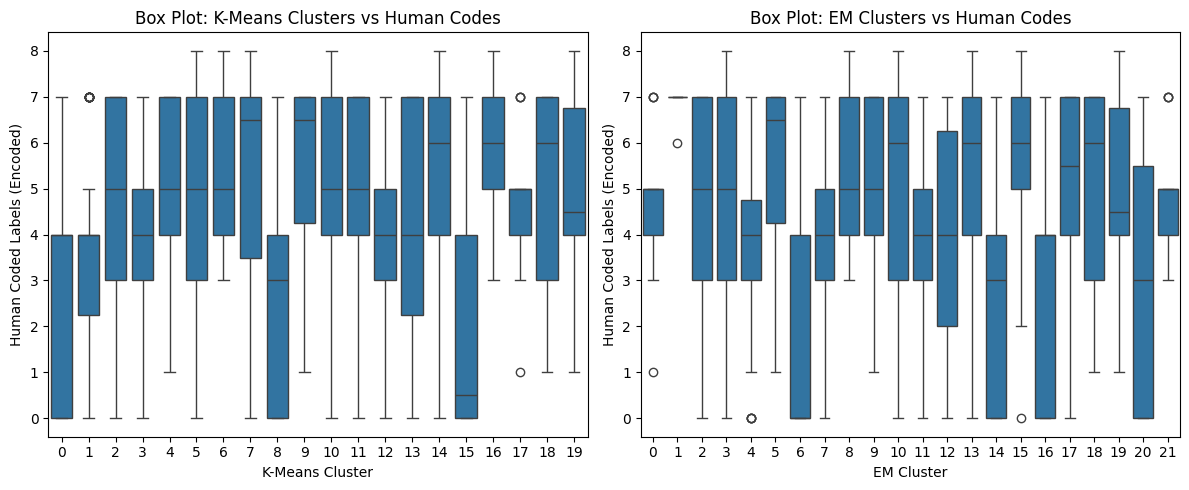

In [20]:
# Box plots to visualize the distribution of 'ut' values across clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='KMeans_Cluster', y='ut_encoded', data=df_clean)
plt.title('Box Plot: K-Means Clusters vs Human Codes')
plt.xlabel('K-Means Cluster')
plt.ylabel('Human Coded Labels (Encoded)')

plt.subplot(1, 2, 2)
sns.boxplot(x='EM_Cluster', y='ut_encoded', data=df_clean)
plt.title('Box Plot: EM Clusters vs Human Codes')
plt.xlabel('EM Cluster')
plt.ylabel('Human Coded Labels (Encoded)')

plt.tight_layout()
plt.show()

In [21]:
# Create a table showing statistical summary of 'ut' values in each cluster
kmeans_summary = df_clean.groupby('KMeans_Cluster')['ut_encoded'].describe()
em_summary = df_clean.groupby('EM_Cluster')['ut_encoded'].describe()

In [22]:
# Display the summary tables
print("Statistical Summary of 'ut' Values in K-Means Clusters:")
print(kmeans_summary)

print("Statistical Summary of 'ut' Values in EM Clusters:")
print(em_summary)

Statistical Summary of 'ut' Values in K-Means Clusters:
                count      mean       std  min   25%  50%   75%  max
KMeans_Cluster                                                      
0                57.0  3.122807  2.390981  0.0  0.00  4.0  4.00  7.0
1                66.0  3.621212  2.196257  0.0  2.25  4.0  4.00  7.0
2                46.0  4.782609  2.128255  0.0  3.00  5.0  7.00  7.0
3                46.0  3.913043  2.158457  0.0  3.00  4.0  5.00  7.0
4                35.0  5.028571  1.932473  1.0  4.00  5.0  7.00  7.0
5                41.0  4.439024  2.608149  0.0  3.00  5.0  7.00  8.0
6                23.0  5.043478  1.551488  3.0  4.00  5.0  7.00  8.0
7                30.0  5.366667  2.251181  0.0  3.50  6.5  7.00  8.0
8               102.0  2.549020  2.127740  0.0  0.00  3.0  4.00  7.0
9                18.0  5.611111  1.786844  1.0  4.25  6.5  7.00  7.0
10               19.0  4.947368  1.985326  0.0  4.00  5.0  7.00  8.0
11               23.0  5.000000  2.000000  0.0 

In [23]:
# Save the summary tables to CSV files
# kmeans_summary.to_csv('kmeans_cluster_summary.csv')
# em_summary.to_csv('em_cluster_summary.csv')

In [24]:
# Summarize the optimal parameters and performance indicators
summary_data = {
    'Algorithm': ['K-Means', 'EM'],
    'Optimal_k': [optimal_k_kmeans, optimal_k_em],
    'Silhouette_Score': [kmeans_metrics['silhouette'][optimal_k_kmeans-2], em_metrics['silhouette'][optimal_k_em-2]],
    'Inertia/AIC': [kmeans_metrics['inertia'][optimal_k_kmeans-2], em_metrics['aic'][optimal_k_em-2]],
    'BIC': [None, em_metrics['bic'][optimal_k_em-2]],  # Inertia is only for K-Means and BIC is only for EM
    'ARI': [ari_kmeans, ari_em],
    'NMI': [nmi_kmeans, nmi_em]
}

summary_df = pd.DataFrame(summary_data)

In [25]:
# Display the summary table
print("Summary of Optimal Parameters and Performance Indicators:")
print(summary_df)

Summary of Optimal Parameters and Performance Indicators:
  Algorithm  Optimal_k  Silhouette_Score   Inertia/AIC           BIC  \
0   K-Means         20          0.707354      9.875420           NaN   
1        EM         22          0.677632 -66791.612288 -46678.856422   

        ARI       NMI  
0  0.033397  0.119974  
1  0.036147  0.131664  


In [26]:
# Save the summary table to a CSV file
#summary_df.to_csv('clustering_summary.csv', index=False)
#print("Summary of clustering saved as 'clustering_summary.csv'")

In [27]:
# Print top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}:")
        print(", ".join(top_words))
        print()

print("Top words for each LDA topic:")
print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Top words for each LDA topic:
Topic #1:
sam, connection, hear, yellow, think, right, kate, got, nolan, switch

Topic #2:
joules, pushes, shocked, close, alright, stephanie, 600, okay, 12, need

Topic #3:
heat, going, number, moves, use, good, okay, ammeter, ok, energy

Topic #4:
wrong, number, crank, generator, dan, 24, 37, got, different, saying

Topic #5:
yeah, think, water, flows, motor, makes, 15, area, lost, okay

Topic #6:
length, jake, second, energy, said, mechanical, inaudible, type, width, ok

Topic #7:
inaudible, nominations, wires, seconds, talking, voltmeter, magician, weird, ohhhh, wire

Topic #8:
current, sends, 400, ball, compass, 14, dimension, hailey, revolmeter, approximately

Topic #9:
alright, temperature, great, oh, density, laughter, vote, million, listening, change

Topic #10:
electrons, circuit, does, good, path, series, megan, work, starts, parallel

Topic #11:
speed, frequency, fast, turn, time, happens, eric, times, ok, distance

Topic #12:
catch, 22, group,